## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
from tensorflow import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [22]:
from keras.layers import Dropout
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128], drop_ratio = 0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for i,n_units in enumerate(num_neurons):
        if i ==0:
            x = keras.layers.Dense(units = n_units,
                                   activation = 'relu',
                                   name = 'hidden_layer' + str(i+1))(input_layer)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units = n_units,
                                  activation = 'relu',
                                  name = 'hidden_layer' + str(i+1))(x)
            x = Dropout(drop_ratio)(x)
        
    out = keras.layers.Dense(units = output_units, activation = 'softmax', name = 'output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [20]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
#MOMENTUM = 0.95

drop_ratio = [0.25,0.1,0.5,0.7]
num_neurons = [[512, 256, 128],
               [512, 256, 128, 64],
               [512, 256, 128, 64, 32]]

In [23]:
import itertools
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for drp_ratio, n_neurons in itertools.product(drop_ratio, num_neurons):
    keras.backend.clear_session()
    print(f'Experiment with Drop_ratop = {drop_ratio}, Num_neurons = {num_neurons}')
    model = build_mlp(input_shape=x_train.shape[1:], num_neurons = n_neurons, drop_ratio = drp_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train,y_train,
              epochs = EPOCHS,
              batch_size = BATCH_SIZE,
              validation_data = (x_test, y_test),
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['accuracy']
    valid_acc = model.history.history['val_accuracy']

    exp_name_tag = f'exp-drp_ratio-{drp_ratio}-num_neurons-{n_neurons}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc' : train_acc,
                             'val-acc'   : valid_acc}

Experiment with Drop_ratop = [0.25, 0.1, 0.5, 0.7], Num_neurons = [[512, 256, 128], [512, 256, 128, 64], [512, 256, 128, 64, 32]]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896   

c:\Users\huang\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
196/196 [==============================] - 3s 12ms/step - loss: 2.0806 - accuracy: 0.2308 - val_loss: 1.8626 - val_accuracy: 0.3312
Epoch 2/50
196/196 [==============================] - 2s 12ms/step - loss: 1.8874 - accuracy: 0.3093 - val_loss: 1.7756 - val_accuracy: 0.3610
Epoch 3/50
196/196 [==============================] - 2s 11ms/step - loss: 1.8327 - accuracy: 0.3350 - val_loss: 1.7009 - val_accuracy: 0.3982
Epoch 4/50
196/196 [==============================] - 2s 11ms/step - loss: 1.7870 - accuracy: 0.3519 - val_loss: 1.6997 - val_accuracy: 0.3939
Epoch 5/50
196/196 [==============================] - 2s 11ms/step - loss: 1.7611 - accuracy: 0.3629 - val_loss: 1.6710 - val_accuracy: 0.4112
Epoch 6/50
196/196 [==============================] - 2s 11ms/step - loss: 1.7372 - accuracy: 0.3701 - val_loss: 1.6333 - val_accuracy: 0.4189
Epoch 7/50
196/196 [==============================] - 2s 13ms/step - loss: 1.7118 - accuracy: 0.3830 - val_loss: 1.6168 - val_accuracy: 0.4368

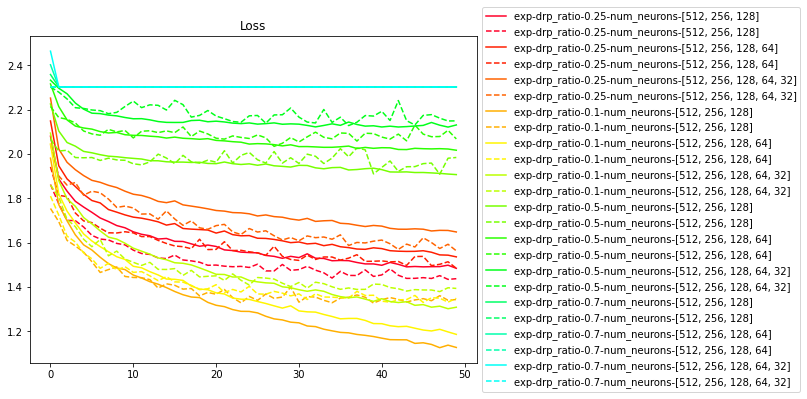

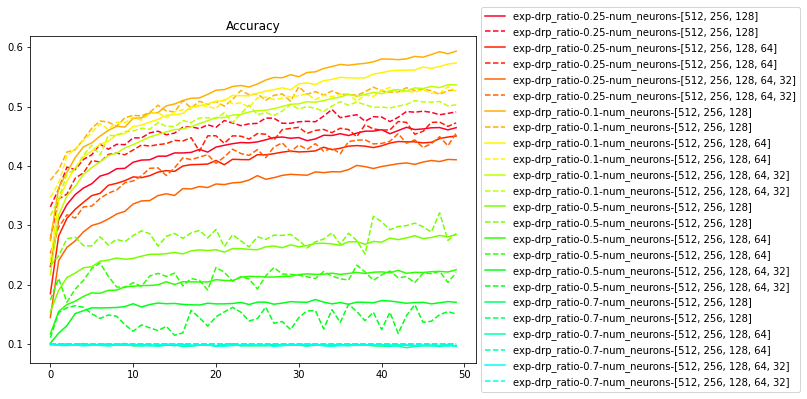

In [24]:
from matplotlib import cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['val-acc'])),results[cond]['val-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()